# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


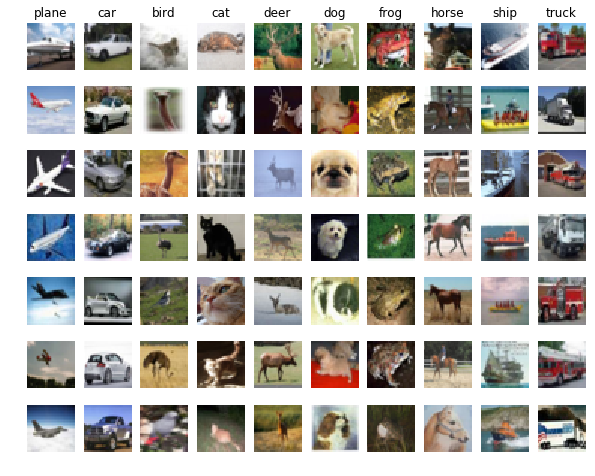

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


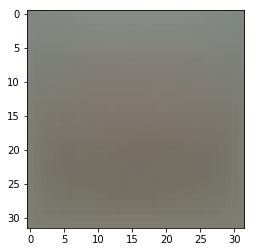

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [25]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.804986


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [213]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 3.527746 analytic: 3.527746, relative error: 3.478012e-11
numerical: -18.008198 analytic: -18.008198, relative error: 1.349387e-11
numerical: 10.755547 analytic: 10.755547, relative error: 7.058492e-12
numerical: 16.852488 analytic: 16.852488, relative error: 1.406351e-11
numerical: 21.402971 analytic: 21.402971, relative error: 1.697223e-11
numerical: 1.402973 analytic: 1.402973, relative error: 3.089983e-10
numerical: 2.893694 analytic: 2.893694, relative error: 5.300706e-11
numerical: -9.383032 analytic: -9.383032, relative error: 1.899671e-11
numerical: -6.966528 analytic: -6.966528, relative error: 3.172505e-11
numerical: 10.270159 analytic: 10.270159, relative error: 6.187057e-12
numerical: 19.031136 analytic: 19.031136, relative error: 1.081534e-11
numerical: -9.619710 analytic: -9.619710, relative error: 1.180325e-11
numerical: -25.996401 analytic: -25.996401, relative error: 2.513073e-11
numerical: -2.118142 analytic: -2.118142, relative error: 4.930832e-11
numerica

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *SVM classifier's loss function contains non-linear component in form of max(0,-) which is only side-differentiable (non-differentiable strictly speaking)*

In [214]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.804986e+00 computed in 0.098818s
Vectorized loss: 8.804986e+00 computed in 0.005006s
difference: -0.000000


In [215]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.098711s
Vectorized loss and gradient: computed in 0.005004s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [270]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 802.120782
iteration 100 / 1500: loss 290.529640
iteration 200 / 1500: loss 109.027074
iteration 300 / 1500: loss 43.266449
iteration 400 / 1500: loss 19.609038
iteration 500 / 1500: loss 10.363808
iteration 600 / 1500: loss 7.418767
iteration 700 / 1500: loss 6.142555
iteration 800 / 1500: loss 5.932457
iteration 900 / 1500: loss 5.217809
iteration 1000 / 1500: loss 5.609217
iteration 1100 / 1500: loss 5.191074
iteration 1200 / 1500: loss 5.405010
iteration 1300 / 1500: loss 5.408652
iteration 1400 / 1500: loss 4.945507
That took 8.043690s


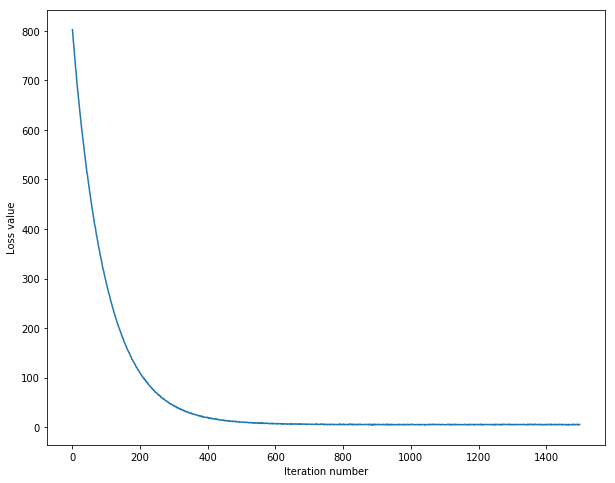

In [271]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [225]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.367612
validation accuracy: 0.377000


In [323]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [0.08e-7,0.1e-7,0.15e-7,0.25e-7]
regularization_strengths = [0.8e4,1.0e4,1.25e4,1.5e4,2e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
from cs231n.classifiers import LinearSVM

num_iters=15000

for l in learning_rates:
    for r in regularization_strengths:
        print("for r=",r," and l=",l)
        svm = LinearSVM()

        svm.train(X_train, y_train, learning_rate=l, reg=r,
                              num_iters=num_iters, verbose=True)
        
        y_train_pred = svm.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        validation_accuracy=np.mean(y_val == y_val_pred)
        results[(l,r)]=(training_accuracy,validation_accuracy) 
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm
            
        print()

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

for r= 8000.0  and l= 8e-09
iteration 0 / 15000: loss 265.995736
iteration 100 / 15000: loss 257.840238
iteration 200 / 15000: loss 249.049314
iteration 300 / 15000: loss 241.344697
iteration 400 / 15000: loss 234.863120
iteration 500 / 15000: loss 228.642843
iteration 600 / 15000: loss 220.803230
iteration 700 / 15000: loss 215.682125
iteration 800 / 15000: loss 210.438758
iteration 900 / 15000: loss 205.850974
iteration 1000 / 15000: loss 199.419436
iteration 1100 / 15000: loss 195.763021
iteration 1200 / 15000: loss 189.775580
iteration 1300 / 15000: loss 186.277083
iteration 1400 / 15000: loss 180.507076
iteration 1500 / 15000: loss 176.819662
iteration 1600 / 15000: loss 172.234130
iteration 1700 / 15000: loss 167.370558
iteration 1800 / 15000: loss 163.441578
iteration 1900 / 15000: loss 159.944168
iteration 2000 / 15000: loss 155.021558
iteration 2100 / 15000: loss 150.632238
iteration 2200 / 15000: loss 147.399787
iteration 2300 / 15000: loss 145.045120
iteration 2400 / 15000: 

iteration 5600 / 15000: loss 56.357312
iteration 5700 / 15000: loss 54.729948
iteration 5800 / 15000: loss 53.008138
iteration 5900 / 15000: loss 51.147622
iteration 6000 / 15000: loss 49.294253
iteration 6100 / 15000: loss 48.503548
iteration 6200 / 15000: loss 47.586787
iteration 6300 / 15000: loss 45.977955
iteration 6400 / 15000: loss 45.364922
iteration 6500 / 15000: loss 43.798734
iteration 6600 / 15000: loss 41.894698
iteration 6700 / 15000: loss 40.844741
iteration 6800 / 15000: loss 39.728197
iteration 6900 / 15000: loss 39.299476
iteration 7000 / 15000: loss 37.826440
iteration 7100 / 15000: loss 36.650120
iteration 7200 / 15000: loss 35.629203
iteration 7300 / 15000: loss 34.794622
iteration 7400 / 15000: loss 33.253774
iteration 7500 / 15000: loss 32.811997
iteration 7600 / 15000: loss 32.026695
iteration 7700 / 15000: loss 31.091327
iteration 7800 / 15000: loss 30.148622
iteration 7900 / 15000: loss 28.719018
iteration 8000 / 15000: loss 28.444168
iteration 8100 / 15000: l

iteration 11400 / 15000: loss 8.688785
iteration 11500 / 15000: loss 8.488342
iteration 11600 / 15000: loss 8.511053
iteration 11700 / 15000: loss 8.829500
iteration 11800 / 15000: loss 8.002723
iteration 11900 / 15000: loss 8.418329
iteration 12000 / 15000: loss 8.111055
iteration 12100 / 15000: loss 7.983513
iteration 12200 / 15000: loss 7.841010
iteration 12300 / 15000: loss 7.450408
iteration 12400 / 15000: loss 7.199281
iteration 12500 / 15000: loss 7.336537
iteration 12600 / 15000: loss 7.528837
iteration 12700 / 15000: loss 7.274017
iteration 12800 / 15000: loss 7.440696
iteration 12900 / 15000: loss 6.986278
iteration 13000 / 15000: loss 6.926089
iteration 13100 / 15000: loss 7.139003
iteration 13200 / 15000: loss 6.748663
iteration 13300 / 15000: loss 6.751740
iteration 13400 / 15000: loss 6.597667
iteration 13500 / 15000: loss 6.852251
iteration 13600 / 15000: loss 6.631410
iteration 13700 / 15000: loss 5.948249
iteration 13800 / 15000: loss 6.894378
iteration 13900 / 15000: 

iteration 2200 / 15000: loss 155.289529
iteration 2300 / 15000: loss 145.409694
iteration 2400 / 15000: loss 137.247946
iteration 2500 / 15000: loss 128.450153
iteration 2600 / 15000: loss 120.639553
iteration 2700 / 15000: loss 113.338901
iteration 2800 / 15000: loss 106.864280
iteration 2900 / 15000: loss 100.626278
iteration 3000 / 15000: loss 93.918049
iteration 3100 / 15000: loss 88.548822
iteration 3200 / 15000: loss 83.535715
iteration 3300 / 15000: loss 78.290312
iteration 3400 / 15000: loss 74.186592
iteration 3500 / 15000: loss 69.156530
iteration 3600 / 15000: loss 65.587245
iteration 3700 / 15000: loss 61.612131
iteration 3800 / 15000: loss 58.523512
iteration 3900 / 15000: loss 55.236881
iteration 4000 / 15000: loss 51.398926
iteration 4100 / 15000: loss 49.208623
iteration 4200 / 15000: loss 46.333936
iteration 4300 / 15000: loss 43.601844
iteration 4400 / 15000: loss 41.124771
iteration 4500 / 15000: loss 38.895859
iteration 4600 / 15000: loss 36.900969
iteration 4700 / 

iteration 8200 / 15000: loss 22.563506
iteration 8300 / 15000: loss 21.782497
iteration 8400 / 15000: loss 20.805683
iteration 8500 / 15000: loss 20.369317
iteration 8600 / 15000: loss 20.330022
iteration 8700 / 15000: loss 19.410941
iteration 8800 / 15000: loss 18.603869
iteration 8900 / 15000: loss 18.413830
iteration 9000 / 15000: loss 18.076934
iteration 9100 / 15000: loss 17.607086
iteration 9200 / 15000: loss 17.174054
iteration 9300 / 15000: loss 16.638014
iteration 9400 / 15000: loss 16.514539
iteration 9500 / 15000: loss 15.641123
iteration 9600 / 15000: loss 15.948095
iteration 9700 / 15000: loss 15.034126
iteration 9800 / 15000: loss 15.819138
iteration 9900 / 15000: loss 15.006861
iteration 10000 / 15000: loss 14.364723
iteration 10100 / 15000: loss 13.542083
iteration 10200 / 15000: loss 13.986999
iteration 10300 / 15000: loss 13.273339
iteration 10400 / 15000: loss 13.299784
iteration 10500 / 15000: loss 13.296632
iteration 10600 / 15000: loss 12.670823
iteration 10700 / 

iteration 14100 / 15000: loss 6.190086
iteration 14200 / 15000: loss 6.125833
iteration 14300 / 15000: loss 6.268120
iteration 14400 / 15000: loss 5.840681
iteration 14500 / 15000: loss 5.443422
iteration 14600 / 15000: loss 5.854646
iteration 14700 / 15000: loss 5.111988
iteration 14800 / 15000: loss 5.516958
iteration 14900 / 15000: loss 5.398241

for r= 12500.0  and l= 1e-08
iteration 0 / 15000: loss 418.646446
iteration 100 / 15000: loss 393.081168
iteration 200 / 15000: loss 371.050762
iteration 300 / 15000: loss 352.223143
iteration 400 / 15000: loss 336.077822
iteration 500 / 15000: loss 317.586052
iteration 600 / 15000: loss 302.557724
iteration 700 / 15000: loss 286.287879
iteration 800 / 15000: loss 273.084422
iteration 900 / 15000: loss 260.544180
iteration 1000 / 15000: loss 246.998656
iteration 1100 / 15000: loss 236.417251
iteration 1200 / 15000: loss 223.999134
iteration 1300 / 15000: loss 212.661403
iteration 1400 / 15000: loss 201.865211
iteration 1500 / 15000: loss 19

iteration 5000 / 15000: loss 27.574347
iteration 5100 / 15000: loss 26.505242
iteration 5200 / 15000: loss 25.017456
iteration 5300 / 15000: loss 23.586785
iteration 5400 / 15000: loss 22.358124
iteration 5500 / 15000: loss 21.546312
iteration 5600 / 15000: loss 20.882129
iteration 5700 / 15000: loss 19.663490
iteration 5800 / 15000: loss 19.291365
iteration 5900 / 15000: loss 18.252062
iteration 6000 / 15000: loss 17.397286
iteration 6100 / 15000: loss 16.563656
iteration 6200 / 15000: loss 16.071321
iteration 6300 / 15000: loss 15.537039
iteration 6400 / 15000: loss 14.825156
iteration 6500 / 15000: loss 13.932608
iteration 6600 / 15000: loss 13.254161
iteration 6700 / 15000: loss 13.533857
iteration 6800 / 15000: loss 12.254738
iteration 6900 / 15000: loss 12.013852
iteration 7000 / 15000: loss 11.763474
iteration 7100 / 15000: loss 11.072380
iteration 7200 / 15000: loss 11.490194
iteration 7300 / 15000: loss 10.981680
iteration 7400 / 15000: loss 10.442559
iteration 7500 / 15000: l

iteration 11100 / 15000: loss 5.241118
iteration 11200 / 15000: loss 5.243533
iteration 11300 / 15000: loss 5.342786
iteration 11400 / 15000: loss 5.025343
iteration 11500 / 15000: loss 5.422427
iteration 11600 / 15000: loss 5.112853
iteration 11700 / 15000: loss 5.117155
iteration 11800 / 15000: loss 5.403682
iteration 11900 / 15000: loss 4.856602
iteration 12000 / 15000: loss 5.108882
iteration 12100 / 15000: loss 5.088516
iteration 12200 / 15000: loss 5.245268
iteration 12300 / 15000: loss 5.374499
iteration 12400 / 15000: loss 4.836278
iteration 12500 / 15000: loss 5.638205
iteration 12600 / 15000: loss 5.237648
iteration 12700 / 15000: loss 4.928683
iteration 12800 / 15000: loss 5.323236
iteration 12900 / 15000: loss 4.986785
iteration 13000 / 15000: loss 4.576551
iteration 13100 / 15000: loss 5.131106
iteration 13200 / 15000: loss 5.214247
iteration 13300 / 15000: loss 5.372781
iteration 13400 / 15000: loss 5.503301
iteration 13500 / 15000: loss 5.346140
iteration 13600 / 15000: 

iteration 2000 / 15000: loss 97.746042
iteration 2100 / 15000: loss 92.175895
iteration 2200 / 15000: loss 86.274797
iteration 2300 / 15000: loss 81.548844
iteration 2400 / 15000: loss 77.198980
iteration 2500 / 15000: loss 72.408640
iteration 2600 / 15000: loss 69.047749
iteration 2700 / 15000: loss 65.426889
iteration 2800 / 15000: loss 61.342977
iteration 2900 / 15000: loss 58.373270
iteration 3000 / 15000: loss 55.526051
iteration 3100 / 15000: loss 52.020526
iteration 3200 / 15000: loss 49.252363
iteration 3300 / 15000: loss 46.753695
iteration 3400 / 15000: loss 43.743352
iteration 3500 / 15000: loss 41.514600
iteration 3600 / 15000: loss 39.496806
iteration 3700 / 15000: loss 37.647104
iteration 3800 / 15000: loss 35.178822
iteration 3900 / 15000: loss 34.317754
iteration 4000 / 15000: loss 32.190872
iteration 4100 / 15000: loss 30.754297
iteration 4200 / 15000: loss 28.962299
iteration 4300 / 15000: loss 27.732096
iteration 4400 / 15000: loss 26.096165
iteration 4500 / 15000: l

iteration 8100 / 15000: loss 5.670645
iteration 8200 / 15000: loss 5.757081
iteration 8300 / 15000: loss 5.748332
iteration 8400 / 15000: loss 5.518204
iteration 8500 / 15000: loss 5.584370
iteration 8600 / 15000: loss 6.399098
iteration 8700 / 15000: loss 5.743392
iteration 8800 / 15000: loss 5.623257
iteration 8900 / 15000: loss 5.021095
iteration 9000 / 15000: loss 5.365308
iteration 9100 / 15000: loss 5.379814
iteration 9200 / 15000: loss 5.580132
iteration 9300 / 15000: loss 5.263896
iteration 9400 / 15000: loss 5.588678
iteration 9500 / 15000: loss 5.249564
iteration 9600 / 15000: loss 5.100167
iteration 9700 / 15000: loss 5.179068
iteration 9800 / 15000: loss 4.783776
iteration 9900 / 15000: loss 4.675028
iteration 10000 / 15000: loss 5.118498
iteration 10100 / 15000: loss 4.936587
iteration 10200 / 15000: loss 5.383225
iteration 10300 / 15000: loss 5.342074
iteration 10400 / 15000: loss 4.668012
iteration 10500 / 15000: loss 5.348125
iteration 10600 / 15000: loss 5.163758
itera

iteration 14200 / 15000: loss 4.757376
iteration 14300 / 15000: loss 4.786871
iteration 14400 / 15000: loss 5.546739
iteration 14500 / 15000: loss 4.775806
iteration 14600 / 15000: loss 4.956537
iteration 14700 / 15000: loss 5.614877
iteration 14800 / 15000: loss 5.330340
iteration 14900 / 15000: loss 5.265474

for r= 20000.0  and l= 1.5e-08
iteration 0 / 15000: loss 640.059679
iteration 100 / 15000: loss 562.767905
iteration 200 / 15000: loss 497.227582
iteration 300 / 15000: loss 441.729003
iteration 400 / 15000: loss 391.742500
iteration 500 / 15000: loss 345.539373
iteration 600 / 15000: loss 306.992541
iteration 700 / 15000: loss 272.419529
iteration 800 / 15000: loss 241.477659
iteration 900 / 15000: loss 215.173386
iteration 1000 / 15000: loss 190.994860
iteration 1100 / 15000: loss 169.758076
iteration 1200 / 15000: loss 151.131281
iteration 1300 / 15000: loss 134.115649
iteration 1400 / 15000: loss 118.926461
iteration 1500 / 15000: loss 106.484345
iteration 1600 / 15000: loss

iteration 5200 / 15000: loss 8.052654
iteration 5300 / 15000: loss 7.864370
iteration 5400 / 15000: loss 8.095728
iteration 5500 / 15000: loss 7.710235
iteration 5600 / 15000: loss 7.682301
iteration 5700 / 15000: loss 7.145379
iteration 5800 / 15000: loss 7.208607
iteration 5900 / 15000: loss 6.541012
iteration 6000 / 15000: loss 6.615639
iteration 6100 / 15000: loss 6.276915
iteration 6200 / 15000: loss 6.313635
iteration 6300 / 15000: loss 6.656233
iteration 6400 / 15000: loss 6.150610
iteration 6500 / 15000: loss 5.686235
iteration 6600 / 15000: loss 6.037206
iteration 6700 / 15000: loss 6.478535
iteration 6800 / 15000: loss 6.162116
iteration 6900 / 15000: loss 5.952908
iteration 7000 / 15000: loss 5.372562
iteration 7100 / 15000: loss 5.576424
iteration 7200 / 15000: loss 5.110302
iteration 7300 / 15000: loss 4.995079
iteration 7400 / 15000: loss 5.289753
iteration 7500 / 15000: loss 5.008848
iteration 7600 / 15000: loss 5.086109
iteration 7700 / 15000: loss 4.682018
iteration 78

iteration 11400 / 15000: loss 5.127893
iteration 11500 / 15000: loss 4.995387
iteration 11600 / 15000: loss 4.921538
iteration 11700 / 15000: loss 4.872477
iteration 11800 / 15000: loss 4.636574
iteration 11900 / 15000: loss 4.460717
iteration 12000 / 15000: loss 4.783952
iteration 12100 / 15000: loss 5.009338
iteration 12200 / 15000: loss 5.153757
iteration 12300 / 15000: loss 5.085997
iteration 12400 / 15000: loss 4.655828
iteration 12500 / 15000: loss 4.836405
iteration 12600 / 15000: loss 5.054044
iteration 12700 / 15000: loss 5.016227
iteration 12800 / 15000: loss 5.038778
iteration 12900 / 15000: loss 5.132850
iteration 13000 / 15000: loss 4.861711
iteration 13100 / 15000: loss 4.732023
iteration 13200 / 15000: loss 4.346042
iteration 13300 / 15000: loss 5.432097
iteration 13400 / 15000: loss 5.070765
iteration 13500 / 15000: loss 4.775299
iteration 13600 / 15000: loss 4.607726
iteration 13700 / 15000: loss 5.576718
iteration 13800 / 15000: loss 4.987805
iteration 13900 / 15000: 

iteration 2500 / 15000: loss 15.754950
iteration 2600 / 15000: loss 14.230161
iteration 2700 / 15000: loss 12.734303
iteration 2800 / 15000: loss 11.110417
iteration 2900 / 15000: loss 10.168564
iteration 3000 / 15000: loss 9.565052
iteration 3100 / 15000: loss 8.953275
iteration 3200 / 15000: loss 8.490757
iteration 3300 / 15000: loss 8.147703
iteration 3400 / 15000: loss 7.420721
iteration 3500 / 15000: loss 7.735662
iteration 3600 / 15000: loss 7.017271
iteration 3700 / 15000: loss 6.883931
iteration 3800 / 15000: loss 6.626088
iteration 3900 / 15000: loss 6.532402
iteration 4000 / 15000: loss 6.066765
iteration 4100 / 15000: loss 6.649096
iteration 4200 / 15000: loss 5.718839
iteration 4300 / 15000: loss 5.706786
iteration 4400 / 15000: loss 6.187822
iteration 4500 / 15000: loss 5.255382
iteration 4600 / 15000: loss 5.562255
iteration 4700 / 15000: loss 4.977978
iteration 4800 / 15000: loss 4.996581
iteration 4900 / 15000: loss 5.383236
iteration 5000 / 15000: loss 5.341226
iterati

iteration 8800 / 15000: loss 5.270192
iteration 8900 / 15000: loss 4.955082
iteration 9000 / 15000: loss 5.759978
iteration 9100 / 15000: loss 5.135258
iteration 9200 / 15000: loss 5.270154
iteration 9300 / 15000: loss 5.156333
iteration 9400 / 15000: loss 4.955937
iteration 9500 / 15000: loss 5.466498
iteration 9600 / 15000: loss 5.177404
iteration 9700 / 15000: loss 5.172606
iteration 9800 / 15000: loss 4.941317
iteration 9900 / 15000: loss 5.630503
iteration 10000 / 15000: loss 5.230581
iteration 10100 / 15000: loss 5.677000
iteration 10200 / 15000: loss 5.397904
iteration 10300 / 15000: loss 5.096037
iteration 10400 / 15000: loss 4.659263
iteration 10500 / 15000: loss 5.059131
iteration 10600 / 15000: loss 4.950207
iteration 10700 / 15000: loss 4.340965
iteration 10800 / 15000: loss 5.079202
iteration 10900 / 15000: loss 5.831789
iteration 11000 / 15000: loss 5.221166
iteration 11100 / 15000: loss 5.188096
iteration 11200 / 15000: loss 4.955436
iteration 11300 / 15000: loss 5.00962

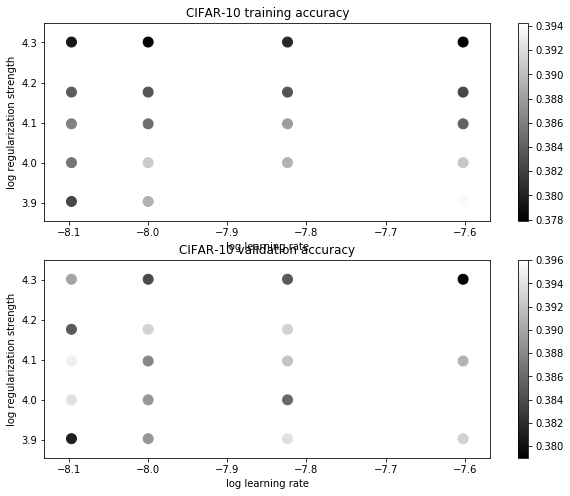

In [324]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [325]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.385000


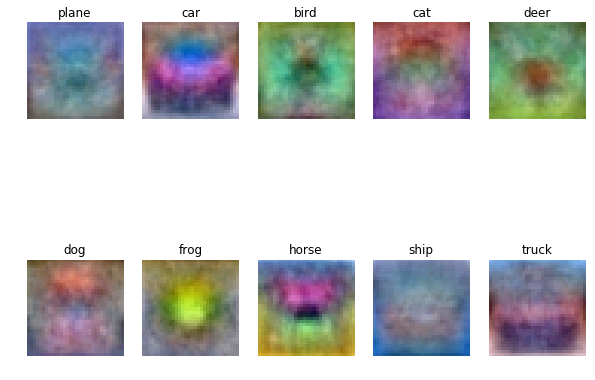

In [322]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** Visualization of SVM weights presented above suggests that for given instance of SVM hyperparameters were picked correctly. It is so, because pictures are fairly smooth and give quite apparent suggestions in terms of the patterns they detect - fronts of cars, green blob for frog, cat's head, ship in the water etc. Noisy visualizations, following the lecture, would suggest unconverged network, improper learning rate or low weight regularization. 

Interestingly enough, in terms of expample given, achieving higher validation accuracy doesn't necessary imply better quality of these visualizations - more aggressive learning rates with lower number of iterations also give validation accuracy of 0.4 however their weights visualizations turned out to be noisy. Only after 'softening' learing process weights visualization smoothed out.